In [1]:
print('welcome')

welcome


C:\Users\pmsum\anaconda3\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


2017-04-30    0.038807
2017-05-31    0.193233
2017-06-30    0.054831
2017-07-31    0.011962
2017-08-31    0.202247
                ...   
2023-11-30    0.151568
2023-12-31    0.177711
2024-01-31   -0.023772
2024-02-29    0.181042
2024-03-31    0.251410
Freq: M, Name: time series, Length: 84, dtype: float64
[[[ 0.15463488]]

 [[ 0.26265002]]

 [[ 0.24030132]]

 [[ 0.23690926]]

 [[ 0.19422388]]

 [[ 0.14046876]]

 [[-0.00193553]]

 [[ 0.15156807]]

 [[ 0.17771073]]

 [[-0.02377232]]

 [[ 0.18104224]]

 [[ 0.25140984]]]
Epoch 1/8
6/6 [==============================] - 9s 237ms/step - loss: 0.1954 - val_loss: 0.0785
Epoch 2/8
6/6 [==============================] - 0s 31ms/step - loss: 0.0260 - val_loss: 0.0394
Epoch 3/8
6/6 [==============================] - 0s 32ms/step - loss: 0.0178 - val_loss: 0.0037
Epoch 4/8
6/6 [==============================] - 0s 30ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 5/8
6/6 [==============================] - 0s 31ms/step - loss: 0.0012 - val_loss: 0.

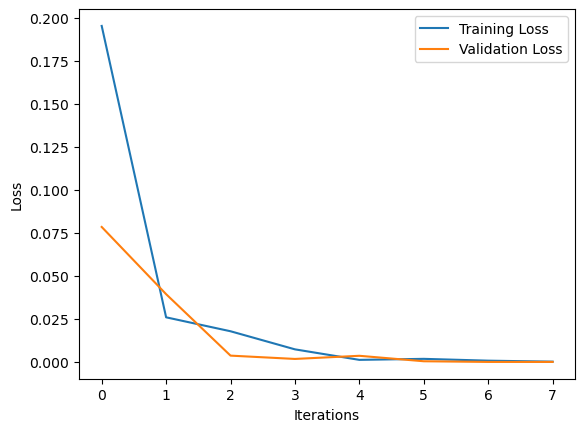

1/1 [==============================] - 1s 897ms/step
[[ 0.15708125]
 [ 0.25836307]
 [ 0.23790638]
 [ 0.23480153]
 [ 0.19464937]
 [ 0.14367683]
 [-0.00342048]
 [ 0.15417144]
 [ 0.17895538]
 [-0.02170122]
 [ 0.18212554]
 [ 0.24807449]]
TCN Model Forecast:
2023-04-30    0.157081
2023-05-31    0.258363
2023-06-30    0.237906
2023-07-31    0.234802
2023-08-31    0.194649
2023-09-30    0.143677
2023-10-31   -0.003420
2023-11-30    0.154171
2023-12-31    0.178955
2024-01-31   -0.021701
2024-02-29    0.182126
2024-03-31    0.248074
Freq: M, Name: forecast, dtype: float32


In [5]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
def calculate_evi(red, blue, nir, scale_factor=2.5, canopy_background_adjustment=1.0):
    red = red.astype(float)
    blue = blue.astype(float)
    nir = nir.astype(float)
    evi = scale_factor * ((nir - red) / (nir + 2.4 * red + 1))
    return evi
def read_images(folder_path):
    evi_values = []
    filee = os.listdir(folder_path)
    filee.sort()
    for filename in filee:
        if filename.endswith(".jpeg"):  
            img_path = os.path.join(folder_path, filename)
            with rasterio.open(img_path) as src:
                red = src.read(3)
                redd = np.mean(red)
                blue = src.read(1)
                bluee = np.mean(blue)
                nir = src.read(2)
                nirr = np.mean(nir)
            
            evi = calculate_evi(redd, bluee, nirr)
            evi_values.append(evi)
    return evi_values
image_folder = r'C:\Users\pmsum\Downloads\MINI PROJECT\final dataset'
time_series_data = read_images(image_folder)
data = pd.Series(time_series_data, index=pd.date_range("4-1-2017", periods=len(time_series_data), freq="M"), name="time series")
print(data)
train_data = data.iloc[:72].values.reshape(-1, 1, 1) 
test_data = data.iloc[72:].values.reshape(-1, 1, 1) 
print(test_data)
input_shape = (train_data.shape[1], train_data.shape[2])
nb_filters = 64
model = Sequential([
    TCN(nb_filters, kernel_size=3, activation='relu', input_shape=input_shape),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(train_data, train_data, epochs=8, batch_size=12, validation_split=0.1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()
forecast = model.predict(test_data)
print(forecast)
forecast_dates = pd.date_range(start=data.index[72], periods=len(forecast), freq='M')
forecast_series = pd.Series(forecast.squeeze(), index=forecast_dates, name='forecast')
print("TCN Model Forecast:")
print(forecast_series)

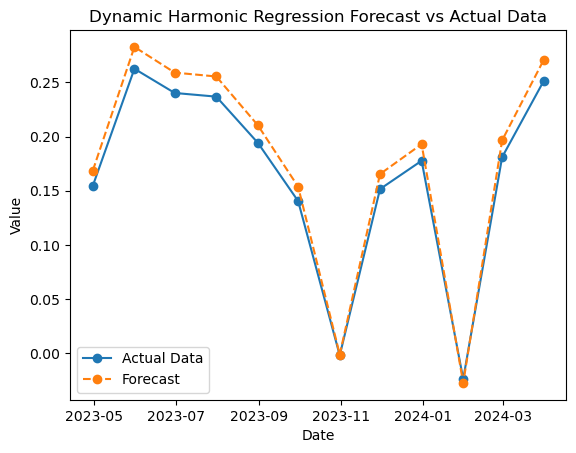

In [3]:
import matplotlib.pyplot as plt
test=data.iloc[72:]
# Plot actual data
plt.plot(test, label='Actual Data', marker='o')

# Plot forecasts
plt.plot(forecast_series, label='Forecast', linestyle='--', marker='o')

# Set plot title and labels
plt.title('Dynamic Harmonic Regression Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Value')

# Add legend
plt.legend()

 # Adjust layout to prevent clipping of labels
plt.show()

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(test_data.squeeze(), forecast.squeeze())
print("Mean Absolute Error:", mae)
percentage_accuracy = 100 - (mae / np.mean(test_data)) * 100
print("Percentage Accuracy:", percentage_accuracy, "%")
pcc = np.abs(np.corrcoef(test_data.squeeze(), forecast.squeeze())[0, 1])
print("PCC:", pcc)
rmse = np.sqrt(mean_squared_error(test_data.squeeze(), forecast.squeeze()))
print("RMSE:", rmse)

Mean Absolute Error: 0.01413232525342914
Percentage Accuracy: 91.37049954963472 %
PCC: 0.9999281858326545
RMSE: 0.015276339904208926
